# Configuration

In [1]:
# The function that handles the logic of printing the stack plot is language_plot
# The logic for the swift versions plot is not wrapped on a function
# Each plot has a title for easy indentification
# Once you are ready to run it make sure the booleans corresponding to the plots you want are on
# Either run the cell that contains the if statement that checks the boolean or just run the whole nootebook
# When running for the very first time an easy way to load all the code is to turn everything off and run the whole notebook
# The code is lazy and will only run the actual retrieval and printing if the option is on

EXAMPLE_PLOT = False
LANG_USAGE_PLOT =  True
SWIFT_VERSIONS_PLOT = True
SWIFT_ADOPTION_PLOT = True
LANG_ADOPTION_PLOT = True
OLD_VS_NEW_SWIFT_PLOTS = True
APPS_PLOT = True
COMPUTE_UNIQUE_REPOS = False  # Do not turn it on unless you want to run this notebook for 10+ hours!
PAPER_STATS = True

### CHANGE ME!! ###
PAPER_REPO = "."
MONGO_URL = 'mongodb://localhost'
DB = 'ios'
CLOC_REPORTS = 'cloc_reports'
CLOC_REPORTS_APPS = 'cloc_reports_apps'
COCOAPODS = 'cocoapods'

import os

def plot_path(name):
    return os.path.join(PAPER_REPO, 'img', name)

In [2]:
from pymongo import MongoClient

def create_client():
    return MongoClient(MONGO_URL)


# Swift versions pipeline

In [3]:
DEBUG_SWIFT_VERSIONS_PIPELINE = False
swift_versions_pipeline = [
    {
        '$match': {
            '$or': [
                {
                    'pushed_with_swift_version': {
                        '$exists': True
                    }
                }, {
                    'swift_version': {
                        '$exists': True
                    }
                }, {
                    'swift_versions': {
                        '$exists': True
                    }
                }
            ]
        }
    }, {
        '$lookup': {
            'from': CLOC_REPORTS, 
            'localField': 'name', 
            'foreignField': 'name', 
            'as': 'reports'
        }
    }, {
        '$addFields': {
            'reports': {
                '$filter': {
                    'input': '$reports', 
                    'cond': {
                        '$eq': [
                            '$$this.version', '$version'
                        ]
                    }
                }
            }
        }
    }, {
        '$unwind': '$reports'
    }, {
        '$project': {
            'name': 1, 
            'version': 1, 
            'swift_version': 1, 
            'swift_versions': 1, 
            'pushed_with_swift_version': 1, 
            'release_date':'$reports.commit_date'
        }
    }
]

if DEBUG_SWIFT_VERSIONS_PIPELINE:
    swift_versions_pipeline.append({
        '$limit': 100
    })


# Paper stats

In [4]:
from datetime import datetime

if PAPER_STATS:
    client = create_client()
    cloc_reports = client[DB][CLOC_REPORTS]
    cloc_reports_apps = client[DB][CLOC_REPORTS_APPS]
    cocoapods = client[DB][COCOAPODS]

    def p(desc, val=-1):
        print(f"{desc}: {val:,d}")

    def number_unique_vals(docs, key):
        return len({x[key] for x in docs})

    # % Number of library versions used for generating the plots
    # \newcommand{\finallibraryversions}{161,883}
    p("Number of library versions used for generating the plots", cloc_reports.count_documents({}))
    # % Number of unique libraries used for generating the plots
    # \newcommand{\finallibraries}{16,447}
    p("Number of unique libraries used for generating the plots", number_unique_vals(cloc_reports.find({}, {'name': 1, '_id': 0}), 'name'))
    # % Number of github repos succesfuly cloned
    # \newcommand{\finalgithubrepos}{24,703}
    # % Number of years or months (TODO) that goes for the study
    # \newcommand{\librariestimewindow}{136 months}
    # %\newcommand{\librariestimewindow}{14 years}
    p("Number of years that goes for the study", number_unique_vals(cloc_reports.aggregate([
        {
            '$match': {
                '$expr': {
                    '$lte': [
                        {'$toDate': '$commit_date'},
                        datetime(2021, 12, 31)
                    ]
                }
            }
        },
        {
            '$project': {
                'year': {
                    '$year': {'$toDate': '$commit_date'}
                }
            }
        }
    ]), 'year'))
    p("Number of months that goes for the study", number_unique_vals(cloc_reports.aggregate([
        {
            '$match': {
                '$expr': {
                    '$lte': [
                        {'$toDate': '$commit_date'},
                        datetime(2021, 12, 31)
                    ]
                }
            }
        },
        {
            '$project': {
                'month': {'$concat': [
                    {'$toString': {'$year': {'$toDate': '$commit_date'}}},
                    '/',
                    {'$toString': {'$month': {'$toDate': '$commit_date'}}}
                ]}
            }
        }
    ]), 'month'))
    # % Number of library versions that are sourced from a git repo
    # \newcommand{\initialgitlibraryversions}{419,393}
    p("Number of library versions that are sourced from a git repo", cocoapods.count_documents({
        '$and': [{'source.git': {'$exists': True}}, {'source.tag': {'$exists': True}}]
    }))
    # % Number of different git repos in all of cocoapods
    # \newcommand{\initialgithubrepos}{72,014}
    # % Number of libraries with at least on release distributed using git
    # \newcommand{\initialgitlibraries}{78,294}
    p("Number of libraries with at least on release distributed using git", number_unique_vals(cocoapods.find({
        '$and': [{'source.git': {'$exists': True}}, {'source.tag': {'$exists': True}}]
    }, {'name': 1,  '_id': 0}), 'name'))
    # % Number of unique libraries in cocoapods
    # \newcommand{\initiallibraries}{82,785}
    p("Number of unique libraries in cocoapods", number_unique_vals(cocoapods.find({'name': {'$exists': True}}, {'name': 1, '_id': 0}), 'name'))
    # % Number of library-versions in cocoapods
    # \newcommand{\initiallibraryversions}{528,409}
    p("Number of library-versions in cocoapods", cocoapods.count_documents({}))
    # % Number of library-versions in the final dataset that declare a swift version
    # \newcommand{\numberswiftversionspecs}{52,375}
    p("Number of library-versions in the final dataset that declare a swift version", next(cocoapods.aggregate(
        swift_versions_pipeline + [{
            '$group': {
                '_id': 0,
                'count': {'$sum': 1}
            }
        }]
    ))['count'])
    p("Number of libraries in the final dataset that declare a swift version", number_unique_vals(cocoapods.aggregate(
        swift_versions_pipeline
    ), 'name'))
    # % Number of apps used in the app's plot
    # \newcommand{\numberapps}{30}
    p("Number of apps used in the app's plot", number_unique_vals(cloc_reports_apps.find({
        'cloc_report.success': True,
        'app': {
            '$not': {
                '$in': list({doc['_id'] for doc in cloc_reports_apps.aggregate([
                    {
                        '$match': {
                            'cloc_report.success': False
                        }
                    },
                    {
                        '$group': {'_id': '$app'}
                    }
                ])})
            }
        }
    }), 'app'))
    # % Number of commits used in the app's plot
    # \newcommand{\totalappscommits}{329,403}
    p("Number of commits used in the app's plot", cloc_reports_apps.count_documents({
        'cloc_report.success': True,
        'app': {
            '$not': {
                '$in': list({doc['_id'] for doc in cloc_reports_apps.aggregate([
                    {
                        '$match': {
                            'cloc_report.success': False
                        }
                    },
                    {
                        '$group': {'_id': '$app'}
                    }
                ])})
            }
        }
    }))
    

Number of library versions used for generating the plots: 161,883
Number of unique libraries used for generating the plots: 25,231
Number of years that goes for the study: 13
Number of months that goes for the study: 137
Number of library versions that are sourced from a git repo: 450,684
Number of libraries with at least on release distributed using git: 77,480
Number of unique libraries in cocoapods: 82,784
Number of library-versions in cocoapods: 528,409
Number of library-versions in the final dataset that declare a swift version: 52,375
Number of libraries in the final dataset that declare a swift version: 8,276
Number of apps used in the app's plot: 38
Number of commits used in the app's plot: 204,846


In [5]:
import pandas as pd

if PAPER_STATS:
    all_langs_pipeline = [
        {
            '$unwind': '$cloc_langs'
        }, {
            '$project': {
                'lang': '$cloc_langs.lang',
                'loc': '$cloc_langs.stats.code'
            }
        }, {
            '$group': {
                '_id': '$lang', 
                'library_versions': {
                    '$sum': 1
                },
                'locs': {
                    '$sum': '$loc'
                }
            }
        }, {
            '$sort': {'locs': -1}
        }, {
            '$project': {
                '_id': 0,
                'Name': '$_id',
                'Releases': '$library_versions',
                'Lines of code': '$locs'
            }
        }
    ]
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        df = pd.DataFrame(cloc_reports.aggregate(all_langs_pipeline))
        print(df.to_markdown())

|    | Name                      |   Releases |   Lines of code |
|---:|:--------------------------|-----------:|----------------:|
|  0 | Objective-C               |      84309 |       214727108 |
|  1 | Swift                     |      69216 |       115231160 |
|  2 | C/C++ Header              |     107104 |        61885536 |
|  3 | C                         |       3272 |        24834241 |
|  4 | C++                       |       1343 |        19312751 |
|  5 | JavaScript                |        281 |         5445147 |
|  6 | Objective-C++             |       2274 |         5101405 |
|  7 | XML                       |      11368 |         3582887 |
|  8 | JSON                      |       1573 |         1218541 |
|  9 | CSS                       |        141 |          576513 |
| 10 | Assembly                  |        122 |          345612 |
| 11 | Markdown                  |       1018 |          258933 |
| 12 | Java                      |         10 |          222141 |
| 13 | YAM

# Example plot

In [6]:
import numpy as np
import matplotlib.pyplot as plt

if EXAMPLE_PLOT:
    # data from United Nations World Population Prospects (Revision 2019)
    # https://population.un.org/wpp/, license: CC BY 3.0 IGO
    year = [1950, 1960, 1970, 1980, 1990, 2000, 2010, 2018]
    population_by_continent = {
        'africa': [228, 284, 365, 477, 631, 814, 1044, 1275],
        'americas': [340, 425, 519, 619, 727, 840, 943, 1006],
        'asia': [1394, 1686, 2120, 2625, 3202, 3714, 4169, 4560],
        'europe': [220, 253, 276, 295, 310, 303, 294, 293],
        'oceania': [12, 15, 19, 22, 26, 31, 36, 39],
    }

    fig, ax = plt.subplots()
    ax.stackplot(year, population_by_continent.values(),
                 labels=population_by_continent.keys(), alpha=0.8)
    ax.legend(loc='upper left')
    ax.tick_params(labelsize = 16, labelrotation=0.45)
    ax.set_title('World population')
    # ax.set_xlabel('Year')
    # ax.set_ylabel('Number of people (millions)')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


    plt.show()

In [7]:
from dateutil.parser import parse

client = create_client()
cloc_reports = client[DB][CLOC_REPORTS]

# Timeline building code

In [8]:
from collections import defaultdict
from datetime import datetime
from dateutil.relativedelta import *

one_month = relativedelta(months=1)
one_day = relativedelta(day=1)


def build_range(from_date, to_date, step):
    """
    Builds the range of dates in the range, by the step.
    """
    current = from_date
    stop = to_date + step
    while current < stop:
        yield current
        current += step


def monthly_range(earliest_date, latest_date):
    earliest_month = datetime(year=earliest_date.year,
                              month=earliest_date.month, day=1)
    latest_month = datetime(year=latest_date.year,
                            month=latest_date.month, day=1)
    return build_range(earliest_month, latest_month, one_month)


def daily_range(earliest_date, latest_date):
    earliest_day = datetime(year=earliest_date.year,
                            month=earliest_date.month, day=earliest_date.day)
    latest_day = datetime(year=latest_date.year,
                          month=latest_date.month, day=latest_date.day)
    return build_range(earliest_day, latest_day, one_day)


class TimelineBuilder:
    def __init__(self, cfg):
        self.cfg = cfg

    def build(self, releases, earliest_date, latest_date):
        releases_timeline = defaultdict(list)

        for release in releases:
            release_date = self.cfg.load_date(release)
            loaded_release = self.cfg.load_release(release)
            if loaded_release:
                releases_timeline[self.cfg.load_key(
                    release)].append(loaded_release)

        timeline = []
        for d in self.cfg.date_range(earliest_date, latest_date):
            latest_releases = self.find_latest_releases(releases_timeline, d)
            if latest_releases:
                timeline.append((self.cfg.date_key(d), latest_releases))
        return sorted(timeline, key=lambda x: x[0])

    def find_latest_releases(self, releases_timeline, moment):
        latest = []
        next_moment = moment + self.cfg.date_step
        for releases in releases_timeline.values():
            previous_releases = [
                release
                for release
                in releases
                if self.cfg.release_date(release) < next_moment
            ]
            if previous_releases:
                latest_release = max(
                    previous_releases, key=self.cfg.release_date)
                latest.append(latest_release)
        return latest


def to_month(d):
    return datetime(year=d.year, month=d.month, day=1)


class MonthlyClocReportsCfg:
    def load_date(self, report):
        return report['commit_date']

    def load_key(self, report):
        return report['name']

    def load_release(self, report):
        return {
            'release': to_month(self.load_date(report)),
            'cloc_langs': report['cloc_langs']
        }

    def date_range(self, earliest_date, latest_date):
        return monthly_range(earliest_date, latest_date)

    def date_key(self, d):
        return d.year, d.month

    def release_date(self, release):
        return release['release']

    date_step = one_month


# Stack plots code

In [9]:
def line_count(report):
    langs_blacklist = {'C/C++ Header'}
    langs_whitelist = {'C', 'C++', 'Objective-C', 'Objective-C++', 'Swift'}
    filtered = [lang for lang in report['cloc_langs'] if lang['lang'] in langs_whitelist]
    loc = defaultdict(int)
    for lang in filtered:
        loc[lang['lang']] = lang['stats']['code']
    return loc


def compute_perc_lang_usage(reports):
    langs = set()
    for report in reports:
        for lang in report.keys():
            langs.add(lang)
            
    total = defaultdict(int)
    for report in reports:
        for lang in langs:
            total[lang] += report[lang]
    total_loc = sum(total.values())

    percs = defaultdict(float)
    for lang, lang_loc in total.items():
        percs[lang] = lang_loc / total_loc
    return percs

def compute_lang_usage(reports):
    langs = set()
    for report in reports:
        for lang in report.keys():
            langs.add(lang)
            
    total = defaultdict(int)
    for report in reports:
        for lang in langs:
            total[lang] += report[lang]
    total_loc = sum(total.values())

    percs = defaultdict(float)
    for lang, lang_loc in total.items():
        percs[lang] = lang_loc
    return percs

MONTH_NAME = [
    None, # Spacer to match month number to name
    "Jan", 'Feb', 'Mar', 'Apr', 'May', "Jun", 'Jul', "Aug", 'Sep', 'Oct', 'Nov', 'Dec'
]

def month_to_str(d):
    year, month = d
    return f"{MONTH_NAME[month]} {year}"

def month_to_year_str(d):
    year, _ = d
    return str(year)

def aggregate_timeline(timeline, prepare_report, normalize=True):
    
    usage_by_lang = defaultdict(list)
    transformed_values = {
        month: (compute_perc_lang_usage if normalize else compute_lang_usage)([x for x in (map(prepare_report, releases)) if x is not None])
        for month, releases
        in timeline
    }
    
    langs = set()
    months = [month_to_str(d) for d in sorted(transformed_values.keys())]
    for row in transformed_values.values():
        for k in row.keys():
            langs.add(k)
    
    for lang in langs:
        usage_by_lang[lang] = [stat for _, stat in sorted([(month, stats[lang]) for month, stats in transformed_values.items()])]
    
    return months, usage_by_lang

def extract_year(month_str):
    #return month_str
    return month_str.split(" ")[1]

def language_plot(months, usage_by_lang, title, y_label, logscale=False, fname=None):
    fig, ax = plt.subplots(figsize=(16,9))
    labels = [_[0] for _ in sorted(usage_by_lang.items(), key=lambda x:x[0], reverse=True)]
    values = [_[1] for _ in sorted(usage_by_lang.items(), key=lambda x:x[0], reverse=True)]
    #months = [m if m.startswith("Jan") else " " for m in months]
    januaries = [i for i, m in enumerate(months) if m.startswith("Jan")]
    years = [extract_year(m) for m in months if m.startswith("Jan")]
    ax.stackplot(months, values,
                 labels=labels, alpha=0.8)
    ax.legend(loc='upper left')
    #ax.set_title(title)
    ax.tick_params(labelsize = 16, labelrotation=0.90)
    # plt.rc('axes', labelsize=16)
    ax.set_xlabel('Months', fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    if logscale:
        ax.set_yscale('log', nonpositive='clip')
    ax.set_xticks(
        #np.arange(0, len(months), 12),
        januaries, years
        # [extract_year(m) for i, m in enumerate(months) if i % 12 == 0]
        )
    plt.show()
    if fname:
        fig.savefig(fname, bbox_inches="tight")

def percs_of_snapshot(data, i):
    final = {}
    for lang, projs in data.items():
        final[lang] = projs[i]
    total = sum(final.values())
    return {
        lang: val / total for lang, val in final.items()
    }

def percs_of_last_snapshot(data):
    snapshot = percs_of_snapshot(data, -1)
    for lang, perc in snapshot.items():
        print(lang, f"{perc*100:0.2f}%")

def nums_in_snapshot(data, i):
    final = {}
    for lang, projs in data.items():
        final[lang] = projs[i]
    return {
        lang: val for lang, val in final.items()
    }

def nums_in_last_snapshot(data):
    snapshot = nums_in_snapshot(data, -1)
    for lang, val in snapshot.items():
        print(lang, f"{val}")

def last_snapshot(data):
    percs_of_last_snapshot(data)
    nums_in_last_snapshot(data)

def zip_lang_with_data(lang, arr):
    for e in arr:
        yield lang, e

def separate_snapshots(data):
    zips = [zip_lang_with_data(lang, snapshots) for lang, snapshots in data.items()]
    return zip(*zips)

def search_month_of_majority(lang, data, months):
    for i, row in enumerate(separate_snapshots(data)):
        if max(row, key=lambda x:x[1])[0] == lang:
            return months[i]

def search_month_of_more_than_50_perc(lang, data, months):
    for i, row in enumerate(separate_snapshots(data)):
        if dict(row)[lang] >= 0.5:
            return months[i]

search_month_of_predominancy = search_month_of_more_than_50_perc

# Language usage plot

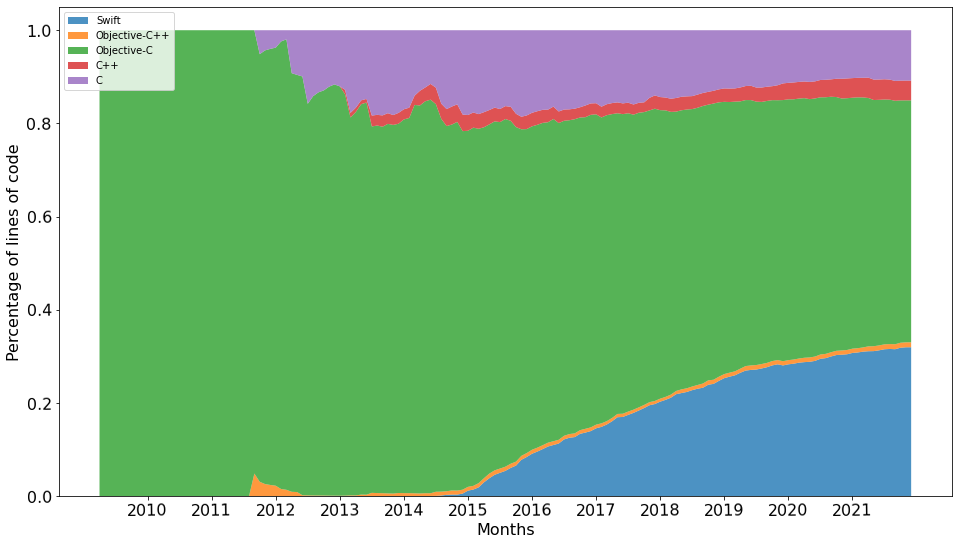

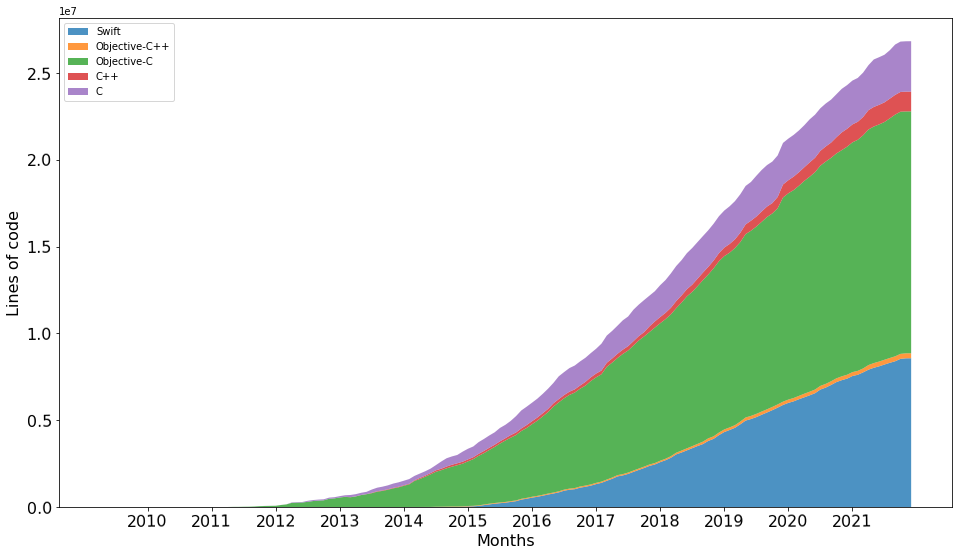

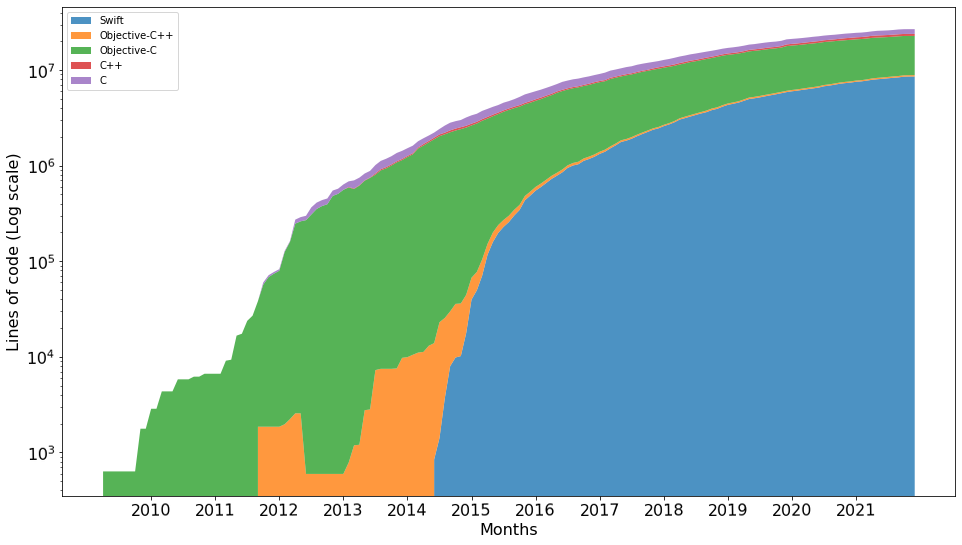

Objective-C 51.92%
C++ 4.24%
Objective-C++ 1.07%
C 10.81%
Swift 31.96%
Objective-C 13927594
C++ 1138236
Objective-C++ 286862
C 2899914
Swift 8573246


In [10]:
if LANG_USAGE_PLOT:
    earliest_date = cloc_reports.find_one({}, {'commit_date': 1, '_id': 0}, sort=[('commit_date', 1)])['commit_date']
#     latest_date = parse(cloc_reports.find_one({}, {'commit_date': 1, '_id': 0}, sort=[('commit_date', -1)])['commit_date'])
    latest_date = datetime(2021, 12, 31)
    # latest_date = datetime(2010, 12, 31)
    raw_reports = cloc_reports.find({})
    timeline = TimelineBuilder(MonthlyClocReportsCfg()).build(raw_reports, earliest_date, latest_date)
    months, data = aggregate_timeline(timeline, line_count)
    language_plot(months, data, 'Language usage over the years (Normalized)', 'Percentage of lines of code', fname=plot_path('lang_usage_norm.png'))
    months, data = aggregate_timeline(timeline, line_count, normalize=False)
    language_plot(months, data, 'Language usage over the years', 'Lines of code', fname=plot_path('lang_usage.png'))
    language_plot(months, data, 'Language usage over the years', 'Lines of code (Log scale)', logscale=True, fname=plot_path('lang_usage_logscale.png'))
    last_snapshot(data)


# Language adoption plot

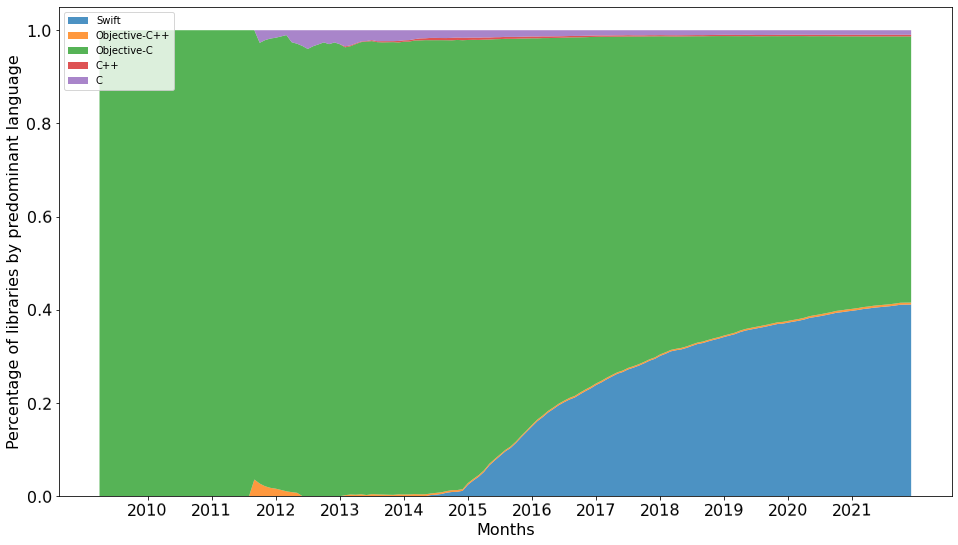

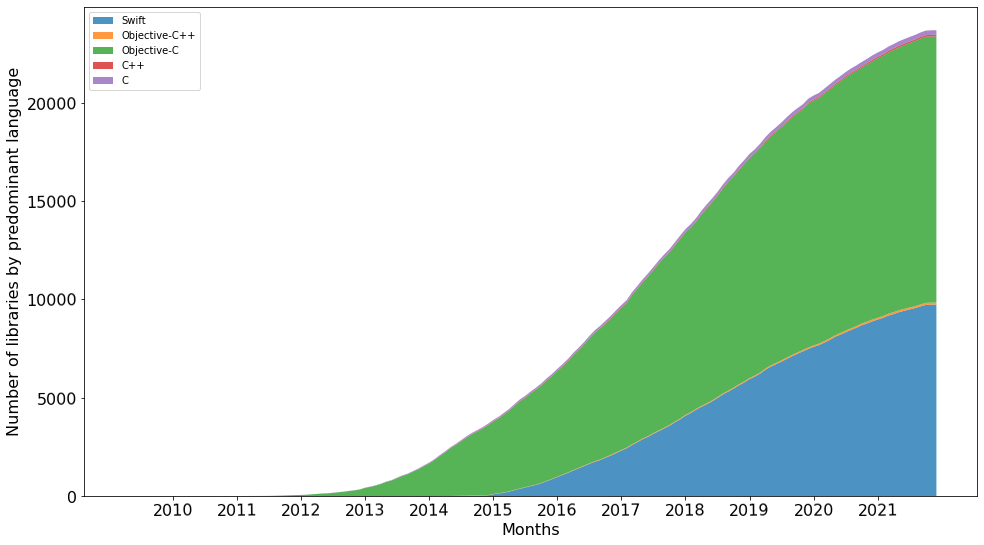

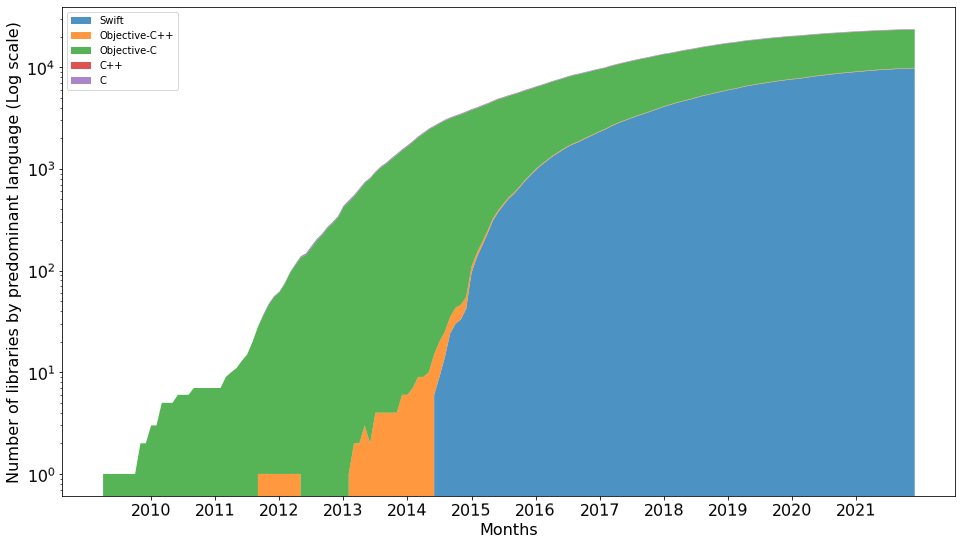

Objective-C 57.12%
C++ 0.35%
Objective-C++ 0.43%
C 0.98%
Swift 41.12%
Objective-C 13523
C++ 83
Objective-C++ 102
C 232
Swift 9734


In [11]:
def most_prevalent_lang(release):
    langs_whitelist = {'C', 'C++', 'Objective-C', 'Objective-C++', 'Swift'}
    langs = [_ for _ in release['cloc_langs'] if _['lang'] in langs_whitelist]
    prevalent = {'lang': None}
    if langs:
        prevalent = max(langs, key=lambda x:x['stats']['code'])
    
    return {lang: int(lang == prevalent['lang']) for lang in langs_whitelist}

def releases_histogram(months, data, title, y_label):
    fig, ax = plt.subplots(figsize=(16,9))
    values = list(map(sum, zip(*[_[1] for _ in sorted(data.items(), key=lambda x:x[0], reverse=True)])))
    ax.bar(months, values, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel(y_label)
    ax.set_xticks(np.arange(0, len(months), 12), [m for i, m in enumerate(months) if i % 12 == 0])
    plt.show()
    
    return values
    
if LANG_ADOPTION_PLOT:
    earliest_date = (cloc_reports.find_one({}, {'commit_date': 1, '_id': 0}, sort=[('commit_date', 1)])['commit_date'])
#     latest_date = (cloc_reports.find_one({}, {'commit_date': 1, '_id': 0}, sort=[('commit_date', -1)])['commit_date'])
    latest_date = datetime(2021, 12, 31)
    raw_reports = cloc_reports.find({})

    timeline = TimelineBuilder(MonthlyClocReportsCfg()).build(raw_reports, earliest_date, latest_date)
    months, data = aggregate_timeline(timeline, most_prevalent_lang)
    language_plot(months, data, 'Predominant language over the years (Normalized)', 'Percentage of libraries by predominant language', fname=plot_path('lang_prevalence_norm.png'))
    months, data = aggregate_timeline(timeline, most_prevalent_lang, normalize=False)
    language_plot(months, data, 'Predominant language over the years', 'Number of libraries by predominant language', fname=plot_path('lang_prevalence.png'))
    language_plot(months, data, 'Predominant language over the years', 'Number of libraries by predominant language (Log scale)', logscale=True, fname=plot_path('lang_prevalence_logscale.png'))
    last_snapshot(data)

#     n_releases = releases_histogram(months, data, 'Number of releases per month', 'Number of releases')
#     import pandas
#     df = pandas.DataFrame(n_releases, index=months)
#     print(df.pct_change().tail(20))

# Swift versions code

In [12]:
from collections import defaultdict

def search_swift_version(v):
    if 'swift_versions' in v:
        if isinstance(v['swift_versions'], list):
            versions = list(map(lambda x: safe_version(str(x)), v['swift_versions']))
            return min(versions), max(versions)
        else:
            return safe_version(v['swift_versions']), safe_version(v['swift_versions'])
    elif 'swift_version' in v:
        assert isinstance(v['swift_version'], str), f"{v}"
        return safe_version(v['swift_version']), safe_version(v['swift_version'])
    elif 'pushed_with_swift_version' in v and v['pushed_with_swift_version']:
        assert isinstance(v['pushed_with_swift_version'], str), f"{v}"
        return safe_version(v['pushed_with_swift_version']), safe_version(v['pushed_with_swift_version'])
    

class MonthlySwiftVersions:
    def load_date(self, report):
        return report['release_date']
    
    def load_key(self, report):
        return report['name']
    
    def load_release(self, report):
        versions = search_swift_version(report)
        if not versions:
            return None
        min_version, max_version = versions
        return {
            'release': to_month(self.load_date(report)),
            'min_swift_version': min_version,
            'max_swift_version': max_version,
            'library': report['name'],
            'version': report['version']
        }
    
    def date_range(self, earliest_date, latest_date):
        return monthly_range(earliest_date, latest_date)
    
    def date_key(self, d):
        return d.year, d.month
    
    def release_date(self, release):
        return release['release']
    
    date_step = one_month

In [13]:
def safe_version(v):
        return fix_y_axis(".".join(tuple(v.split('.')[:2])).split("\n")[0])

def fix_y_axis(entry):
    return float({
        '"4.0"': 4.0,
        'echo "3.2" >>': 3.2,
        '"3.0"': 3.0,
        '`echo "3.0" >': 3.0,
        '`echo "3.0" > ': 3.0,
        'echo "4.0" >>': 4.0,
        '3.0 =': 3.0,
        'echo "3.0" >>': 3.0,
        'echo 4.0 >': 4.0,
        'echo 3.0 >': 3.0,
        '3.0-GM-CANDIDATE': 3.0,
        '4.0-DEVELOPMENT-SNAPSHOT-2017-08-04-a': 4.0,
        '4.0-DEVELOPMENT-SNAPSHOT-2017-07-28-a': 4.0,
        '3.0\n3': 3.0,
        'echo "3.0" >> ': 3.0,
        'echo 3.0 > ': 3.0,
        'echo 4.0 > ': 4.0,
        'echo “3.0” >> ': 3.0,
        'echo "4.0" > ': 4.0,
        '3.1\n3': 3.1,
        'echo "4.0" >> ': 4.0,
        '“3.0”': 3.0,
        'echo "3.2" >> ': 3.2,
        '“4.0”': 4.0
    }.get(entry, entry))

# fix_y_axis('`echo "3.0" >')

# Swift versions plot

Number of library versions with swift version: 52375
\newcommand{\MajorSwiftUpgrades}{72.82\%\xspace}
\newcommand{\MinorSwiftUpgrades}{27.18\%\xspace}


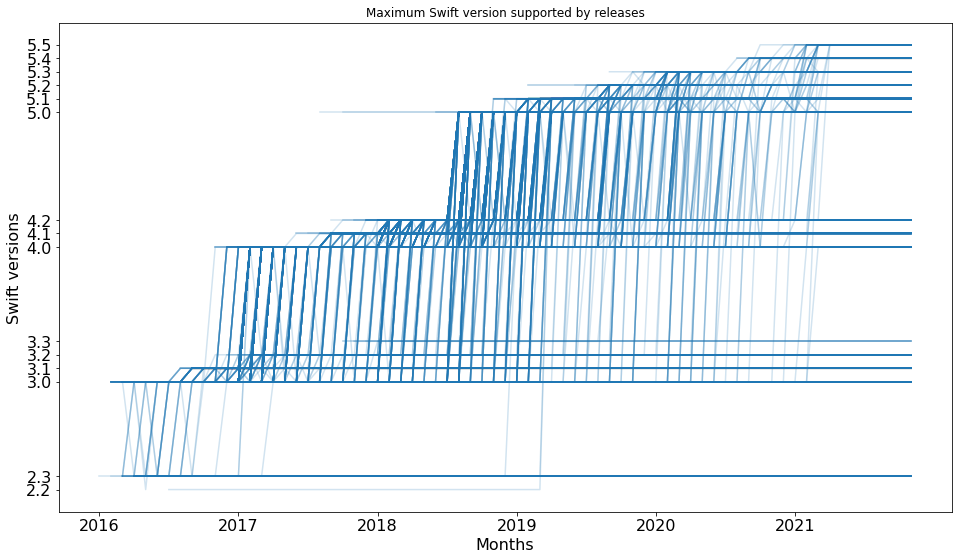

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def line_plot_per_library(timeline):
    min_versions = defaultdict(list)
    max_versions = defaultdict(list)
    
    for month, releases in timeline:
        for release in releases:
            min_versions[release['library']].append((month, release['min_swift_version']))
            max_versions[release['library']].append((month, release['max_swift_version']))
            
    return min_versions, max_versions

if SWIFT_VERSIONS_PLOT:
    client = create_client()
    swift_versions = list(client[DB][COCOAPODS].aggregate(swift_versions_pipeline))

    earliest_date = min(v['release_date'] for v in swift_versions)
    latest_date = max(v['release_date'] for v in swift_versions)
    print("Number of library versions with swift version:", len(swift_versions))
    swift_versions_timeline = TimelineBuilder(MonthlySwiftVersions()).build(swift_versions, earliest_date, latest_date)
    
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(1, 1, 1)
    
    min_versions, max_versions = line_plot_per_library(swift_versions_timeline)
    total = 0
    minors = 0
    majors = 0
    for lib, releases in max_versions.items():
        last = None
        for _, release in releases:
            if last:
                if int(release) > int(last):
                    majors += 1
                    break
                elif release > last:
                    minors += 1
                    break
            last = release
    print(f"\\newcommand{{\\MajorSwiftUpgrades}}{{{majors / (minors + majors) * 100:0.2f}\\%\\xspace}}")
    print(f"\\newcommand{{\\MinorSwiftUpgrades}}{{{minors / (minors + majors) * 100:0.2f}\\%\\xspace}}")
    months = [month_to_str(month) for month, _ in swift_versions_timeline]
        
    all_versions = set()
    for max_version_plot in max_versions.values():
        dates = [month_to_str(_[0]) for _ in max_version_plot]
        versions = [safe_version(str(_[1])) for _ in max_version_plot]
        for version in versions:
            all_versions.add(version)
        color = "tab:blue"
        ax.plot(dates, versions, color=color, alpha=0.2)
    ax.tick_params(labelsize = 16)
    ax.set_xticks(np.arange(0, len(months), 12), [extract_year(m) for i, m in enumerate(months) if i % 12 == 0])
    ax.set_yticks(sorted(all_versions), [str(v) for v in sorted(all_versions)])
    

    ax.set_xlabel('Months', fontsize=16)
    ax.set_ylabel("Swift versions", fontsize=16)
    ax.set_title('Maximum Swift version supported by releases')

    plt.show()

    fig.savefig(plot_path('swift_versions.png'), bbox_inches="tight")
    
   
    
        

In [15]:
if SWIFT_VERSIONS_PLOT:
    client = create_client()
    total = 0
    libs = []
    for lib, versions in max_versions.items():
        x = list(map(lambda x: safe_version(str(x[1])), versions))
        if x != sorted(x):
            # print(f"{lib} at some point lowers the maximum version!")
            total += 1
            libs.append(lib)
            
    def pred(v):
        return ('swift_version' in v or 'swift_versions' in v or 'pushed_with_swift_version' in v) and 'tag' in v['source']

    total = set()
    for lib in libs:
        versions = client[DB][COCOAPODS].find({'name': lib}, {
            'version': 1,
            'swift_version': 1,
            'swift_versions': 1,
            # 'pushed_with_swift_version': 1,
            'source': 1
        })

        sorted_versions = sorted((v for v in versions if pred(v)), key=lambda x: x['version'])
        last_version = None
        last_tag = None
        for version in sorted_versions:
            searched_version = search_swift_version(version)
            if not searched_version:
                continue
            min_ver, max_ver = searched_version
            if last_version and max_ver < last_version:
                total.add(lib)
                print(f"Max version lowered in {lib}!")
                print(f"\tRepo: {version['source']['git']}")
                print(f"\tPrevious release tag: {last_tag}")
                print(f"\tRelease when they lowered the version: {version['source']['tag']}")
                print() # Spacer
            last_version = max_ver
            last_tag = version['source']['tag']

        
    print(f"A total of {len(total)} libraries lower the maximum Swift version at some point.")
    

Max version lowered in AlamofireImage!
	Repo: https://github.com/Alamofire/AlamofireImage.git
	Previous release tag: 4.0.0
	Release when they lowered the version: 4.0.0-beta.1

Max version lowered in Viperit!
	Repo: https://github.com/ferranabello/Viperit.git
	Previous release tag: 1.4.4
	Release when they lowered the version: 1.5.0

Max version lowered in Siren!
	Repo: https://github.com/ArtSabintsev/Siren.git
	Previous release tag: 5.4.1
	Release when they lowered the version: 5.4.2

Max version lowered in Pageboy!
	Repo: https://github.com/MerrickSapsford/Pageboy.git
	Previous release tag: 3.2.0
	Release when they lowered the version: 3.2.1

Max version lowered in CreditCardValidator!
	Repo: https://github.com/vitkuzmenko/CreditCardValidator.git
	Previous release tag: 0.5.1
	Release when they lowered the version: 0.5.2

Max version lowered in PinLayout!
	Repo: https://github.com/mirego/PinLayout.git
	Previous release tag: 1.10.0
	Release when they lowered the version: 1.7.0

Max ver

In [16]:
from collections import defaultdict

def flatten_list_gen(e):
    if isinstance(e, list):
        for i in e:
            yield from flatten_list(i)
    else:
        yield e

def flatten_list(e):
    return list(flatten_list_gen(e))

# Percentage of libraries in dataset that target swift 5 (latest release of each?) [DONE]
# Percentage of upgrades to major releases [DONE]
# Percentage of upgrades to minor releases [DONE]
# Percentage of swift 3 libraries with last release older than 4 years ago [DONE]
# Percentage of swift 4 libraries with last release older than 2 years ago [DONE]

if SWIFT_VERSIONS_PLOT:  # We are done with this part
    client = create_client()
    libraries = client[DB][COCOAPODS].aggregate(swift_versions_pipeline + [
        {
            '$group': {
                '_id': '$name',
                'latest_date': {
                    '$max': '$release_date'
                }
            }
        }
    ])
    latest_releases = defaultdict(list)
    for library in libraries:
        swift_versions = client[DB][CLOC_REPORTS].aggregate([
            {
                '$match': {
                    'name': library['_id'],
                    'commit_date': library['latest_date']
                }
            }, {
                '$lookup': {
                    'from': COCOAPODS, 
                    'localField': 'name', 
                    'foreignField': 'name', 
                    'as': 'pod'
                }
            }, {
                '$unwind': '$pod'
            }, {
                '$match': {
                    '$expr': {
                        '$eq': ['$version', '$pod.version']
                    }
                }
            }, {
                '$project': {
                    '_id': 0,
                    'swift_versions': '$pod.swift_versions',
                    'swift_version': '$pod.swift_version',
                    'pushed_with_swift_version': '$pod.pushed_with_swift_version'
                }
            }
        ])
        search_result = search_swift_version(next(swift_versions))
        if search_result:
            _, max_version = search_result
            max_version = int(max_version)
            latest_releases[max_version].append((datetime.today() - library['latest_date']).days)  # We only keep how many days have passed

    def avg(x):
        if len(x) == 0:
            return 0
        else:
            return sum(x) / len(x)

    def number_of_too_old(days, limit):
        total = len(days)
        return sum(1 for x in days if x > limit) / total

    print(f"\\newcommand{{\\Swift3TooOld}}{{{number_of_too_old(latest_releases[3], 365 * 4) * 100:0.2f}\\%\\xspace}}")
    print(f"\\newcommand{{\\Swift4TooOld}}{{{number_of_too_old(latest_releases[4], 365 * 2) * 100:0.2f}\\%\\xspace}}")
    total = sum(len(x) for x in latest_releases.values())
    print(f"\\newcommand{{\\Swift5VSOthers}}{{{(len(latest_releases[5]) / total) * 100:0.2f}\\%\\xspace}}")
    print(f"\\newcommand{{\\SwiftFourVSOthers}}{{{(len(latest_releases[4]) / total) * 100:0.2f}\\%\\xspace}}")
    print(f"\\newcommand{{\\SwiftThreeVSOthers}}{{{(len(latest_releases[3]) / total) * 100:0.2f}\\%\\xspace}}")
    
    # n_versions = len(latest_releases.keys())
    # for version, days in latest_releases.items():
    #     fig = plt.figure(figsize=(16,9))
    #     ax = fig.add_subplot(1, 1, 1)
    #     ax.hist(days, bins=100)
    #     ax.set_title(f"Histogram of days since last release for major version {version} (n={len(days)}) (avg={avg(days)})")


\newcommand{\Swift3TooOld}{98.21\%\xspace}
\newcommand{\Swift4TooOld}{88.42\%\xspace}
\newcommand{\Swift5VSOthers}{51.90\%\xspace}
\newcommand{\SwiftFourVSOthers}{28.94\%\xspace}
\newcommand{\SwiftThreeVSOthers}{18.91\%\xspace}


# Swift adoption plot

Found the libs from before Swift existed


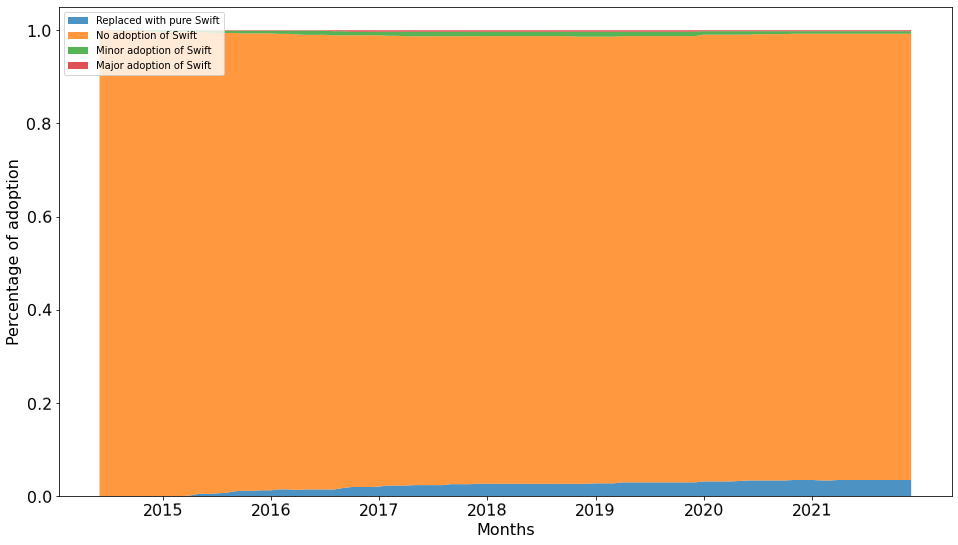

Major adoption of Swift 0.21%
No adoption of Swift 95.79%
Minor adoption of Swift 0.53%
Replaced with pure Swift 3.48%
Major adoption of Swift 0.002107481559536354
No adoption of Swift 0.9578503688092729
Minor adoption of Swift 0.005268703898840885
Replaced with pure Swift 0.03477344573234984


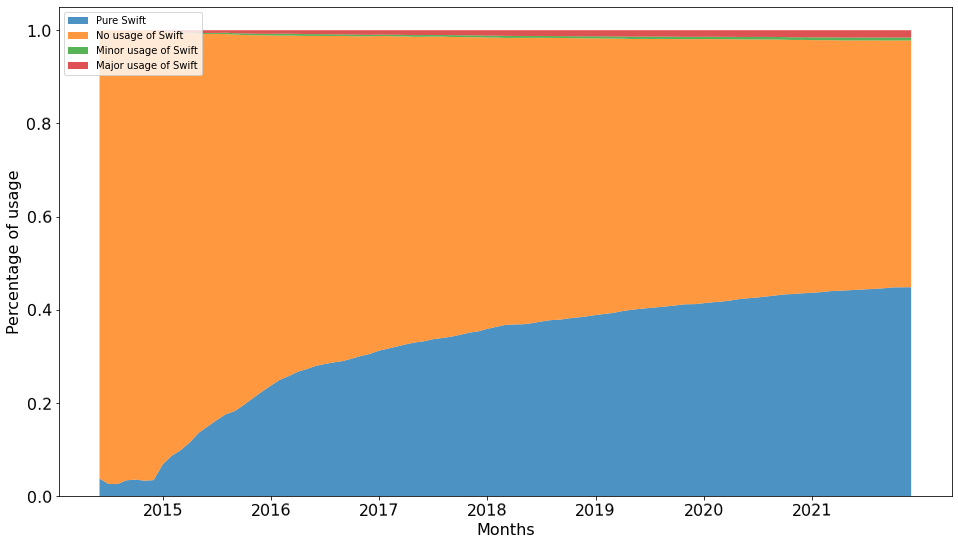

Pure Swift 44.84%
Minor usage of Swift 0.62%
No usage of Swift 52.96%
Major usage of Swift 1.58%
Pure Swift 9395
Minor usage of Swift 130
No usage of Swift 11095
Major usage of Swift 330
Found the libs from before Swift existed


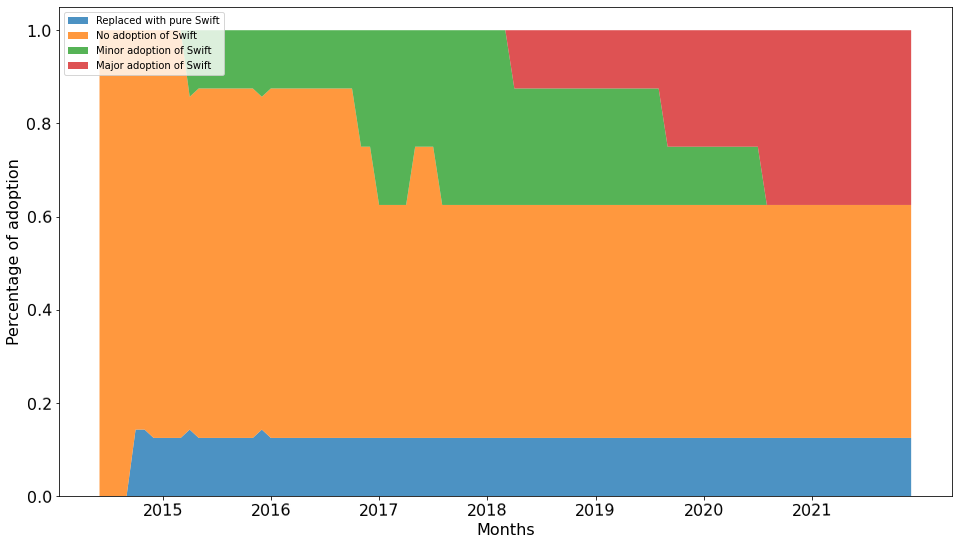

Major adoption of Swift 37.50%
No adoption of Swift 50.00%
Minor adoption of Swift 0.00%
Replaced with pure Swift 12.50%
Major adoption of Swift 0.375
No adoption of Swift 0.5
Minor adoption of Swift 0.0
Replaced with pure Swift 0.125


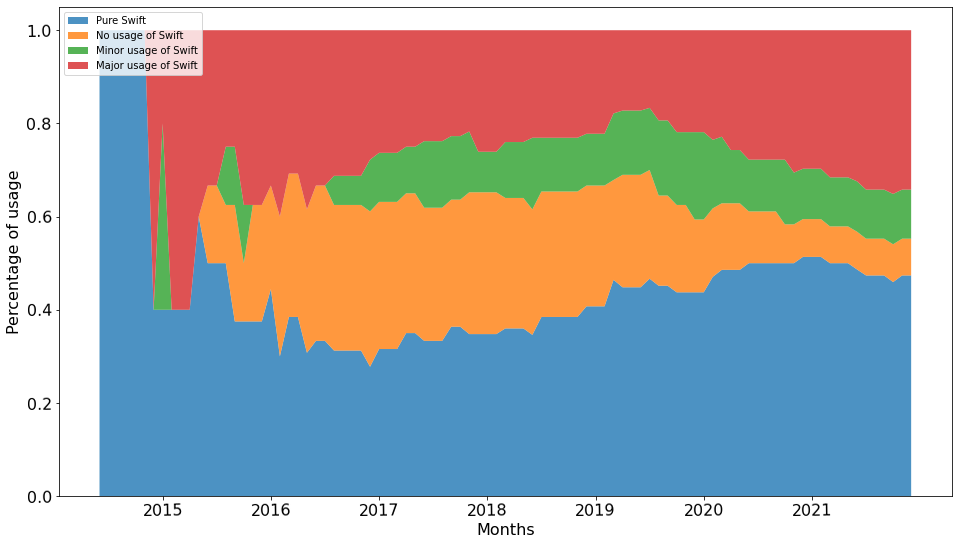

Pure Swift 47.37%
Minor usage of Swift 10.53%
No usage of Swift 7.89%
Major usage of Swift 34.21%
Pure Swift 18
Minor usage of Swift 4
No usage of Swift 3
Major usage of Swift 13


In [17]:

def find_report_for_libs(report):
    return report['cloc_langs']

def find_report_for_apps(report):
    if 'cloc_report' not in report:
        return []
    if 'langs' not in report['cloc_report']:
        return []
    return report['cloc_report']['langs']

def plot_old_vs_new(collection, key, date_key, find_report, fname):
    class MonthlyClocReportsCfg:
        def load_date(self, report):
            return report[date_key]

        def load_key(self, report):
            return report[key]

        def load_release(self, report):
            return {
                'release': to_month(self.load_date(report)),
                'cloc_langs': find_report(report)
            }

        def date_range(self, earliest_date, latest_date):
            return monthly_range(earliest_date, latest_date)

        def date_key(self, d):
            return d.year, d.month

        def release_date(self, release):
            return release['release']

        date_step = one_month
    
    latest_date = datetime(2021, 12, 31)

    # June 2, 2014
    first_swift_release = datetime(2014, 6, 2)
    "2014-06-02 00:00:00+00:00"
    
    libs_before = client[DB][collection].aggregate([
        {
            '$addFields': {
                date_key: {'$toDate': f'${date_key}'}
            }
        }, {
            '$match': {
                '$expr': {
                    '$lte': [
                        f"${date_key}",
                        first_swift_release
                    ]
                }
            }
        }, {
            '$project': {
                '_id': 0,
                key: 1
            }
        }
    ])
    
    libs_before = list({x[key] for x in libs_before})
    print("Found the libs from before Swift existed")
    releases_after = client[DB][collection].aggregate([
        {
            '$addFields': {
                date_key: {'$toDate': f'${date_key}'}
            }
        }, {
            '$match': {
                '$expr': {
                    '$gt': [
                        f'${date_key}',
                        first_swift_release
                    ]
                }
            }
        }, {
            '$match': {
                '$expr': {
                    '$lt': [
                        f'${date_key}',
                        datetime(2022, 1, 1)
                    ]
                }
            }
        }
        
    ])
    
    releases_of_old = []
    releases_of_new = []
    
    for release in releases_after:
        if release[key] in libs_before:
            releases_of_old.append(release)
        else:
            releases_of_new.append(release)
    
    def classify_old_release(release):
        objc_loc = 0
        swift_loc = 0
        total = 0
        other = 0
        langs_whitelist = {'C', 'C++', 'Objective-C', 'Objective-C++', 'Swift'}
        
        for lang in release['cloc_langs']:
            if lang['lang'] in langs_whitelist:
                total += lang['stats']['code']
                if lang['lang'] == 'Swift':
                    swift_loc = lang['stats']['code']
                if lang['lang'] == 'Objective-C':
                    objc_loc = lang['stats']['code']
        if total == 0:
            other = 1
            objc_ptc = 0
            swift_ptc = 0
        else:
            objc_ptc = float(objc_loc) / float(total)
            swift_ptc = float(swift_loc) / float(total)
        no_swift = swift_ptc == 0.0 and other == 0 and objc_ptc > 0.0
        swift_as_adapter = swift_ptc > 0.0 and objc_ptc > swift_ptc and other == 0
        major_adoption = swift_ptc > objc_ptc and other == 0 and swift_ptc < 1.0
        replaced_with_swift = swift_ptc == 1.0 and other == 0

        if not (no_swift or 
                swift_as_adapter or 
                major_adoption or 
                replaced_with_swift):
            other = 1
        row = {
            'No adoption of Swift': int(no_swift),
            'Minor adoption of Swift': int(swift_as_adapter),
            'Major adoption of Swift': int(major_adoption),
            'Replaced with pure Swift': int(replaced_with_swift),
        }
        assert sum(row.values()) == 1 or other == 1, f"Double count or undercount error:\n{row}"  # Ensure we dont have double counts
        return row
    
    def classify_new_release(release):
        objc_loc = 0
        swift_loc = 0
        total = 0
        other = 0
        langs_whitelist = {'C', 'C++', 'Objective-C', 'Objective-C++', 'Swift'}
        
        for lang in release['cloc_langs']:
            if lang['lang'] in langs_whitelist:
                total += lang['stats']['code']
                if lang['lang'] == 'Swift':
                    swift_loc = lang['stats']['code']
                if lang['lang'] == 'Objective-C':
                    objc_loc = lang['stats']['code']
        if total == 0:
            other = 1
            objc_ptc = 0
            swift_ptc = 0
        else:
            objc_ptc = float(objc_loc) / float(total)
            swift_ptc = float(swift_loc) / float(total)

        no_swift = swift_ptc == 0.0 and other == 0 and objc_ptc > 0.0
        swift_as_adapter = swift_ptc > 0.0 and objc_ptc > swift_ptc and other == 0
        major_adoption = swift_ptc > objc_ptc and other == 0 and swift_ptc < 1.0
        pure_swift = swift_ptc == 1.0 and other == 0

        if not (no_swift or 
                swift_as_adapter or 
                major_adoption or 
                pure_swift):
            other = 1
        row = {
            'No usage of Swift': int(no_swift),
            'Minor usage of Swift': int(swift_as_adapter),
            'Major usage of Swift': int(major_adoption),
            'Pure Swift': int(pure_swift),
        }
        assert sum(row.values()) == 1 or other == 1, f"Double count error:\n{row}"  # Ensure we dont have double counts
        return row
            
    
    # Find all the libraries that existed before first_swift_release
    # For all those libraries get all the releases after first_swift_release
    # 4 types:
    # - 0# Swift (No adoption of Swift)
    # - # Swift < # ObjC (Core still in ObjC and Swift as adapter)
    # - # Swift > # ObjC (Major adoption of Swift)
    # - # Swift ~= # ObjC (Both languages well supported?)
    old_timeline = TimelineBuilder(MonthlyClocReportsCfg()).build(releases_of_old, first_swift_release, latest_date)
    months, data = aggregate_timeline(old_timeline, classify_old_release)
    language_plot(months, data, 'Adoption of Swift of pre-existing libraries', 'Percentage of adoption', fname=plot_path(f'{fname}_before.png'))
    last_snapshot(data)
    # For all libraries that are brand new after first_swift_release
    # 4 types:
    # - 0# Swift (No usage of Swift)
    # - # Swift < # ObjC (Core in ObjC with Swift layer)
    # - # Swift > # ObjC (Swift first library)
    # - 100# Swift (Pure Swift library)
    new_timeline = TimelineBuilder(MonthlyClocReportsCfg()).build(releases_of_new, first_swift_release, latest_date)
    months, data = aggregate_timeline(new_timeline, classify_new_release)
    language_plot(months, data, 'Usage of Swift in brand new libraries', 'Percentage of usage', fname=plot_path(f'{fname}_after.png'))
    months, data = aggregate_timeline(new_timeline, classify_new_release, normalize=False)
    last_snapshot(data)
    
if OLD_VS_NEW_SWIFT_PLOTS:
    plot_old_vs_new('cloc_reports', 'name', 'commit_date', find_report_for_libs, 'swift_adoption')
    plot_old_vs_new('cloc_reports_apps_v2', 'app', 'date', find_report_for_apps, 'swift_adoption_apps')


# Apps plot

Objective-C 12.84%
C++ 1.98%
Objective-C++ 0.52%
C 11.98%
Swift 72.68%
Objective-C 171153
C++ 26372
Objective-C++ 6892
C 159768
Swift 968992


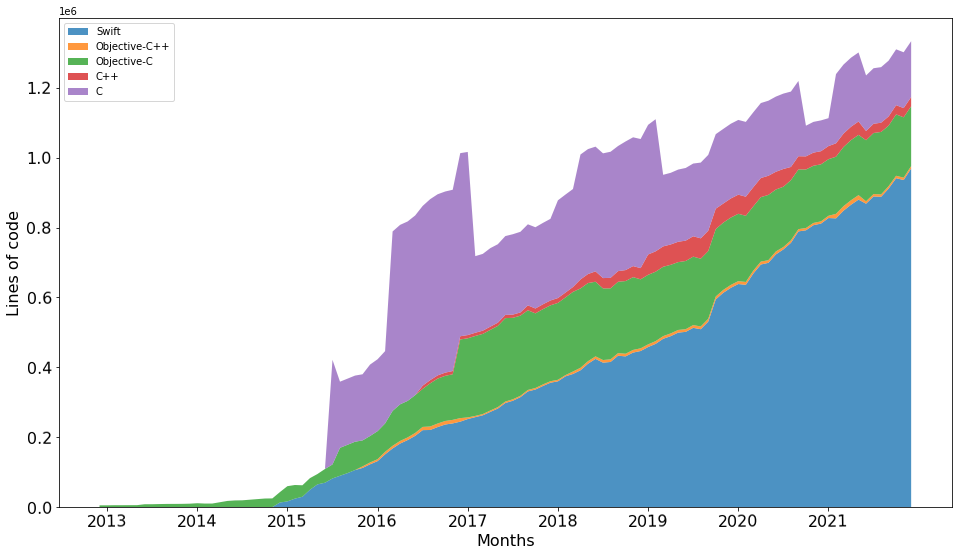

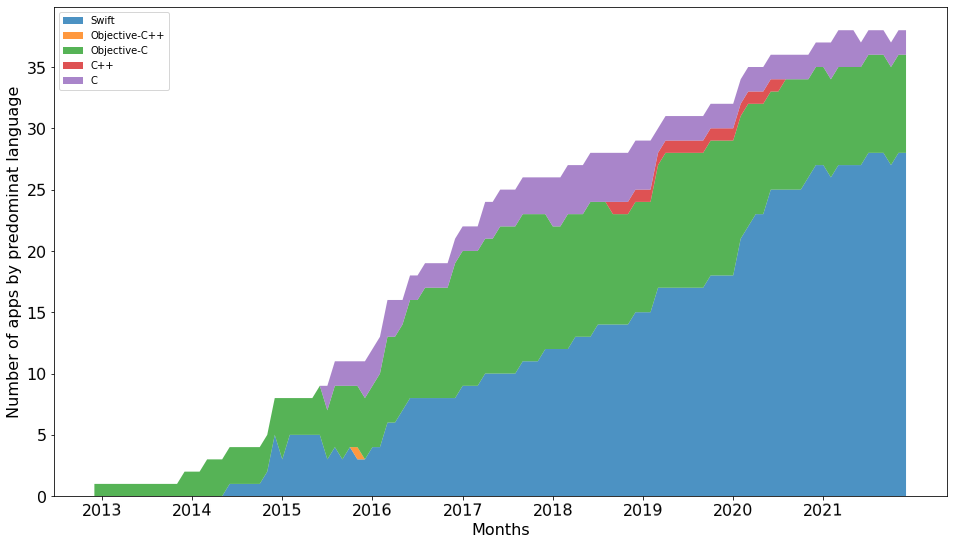

Objective-C 21.05%
C++ 0.00%
Objective-C++ 0.00%
C 5.26%
Swift 73.68%
Objective-C 8
C++ 0
Objective-C++ 0
C 2
Swift 28


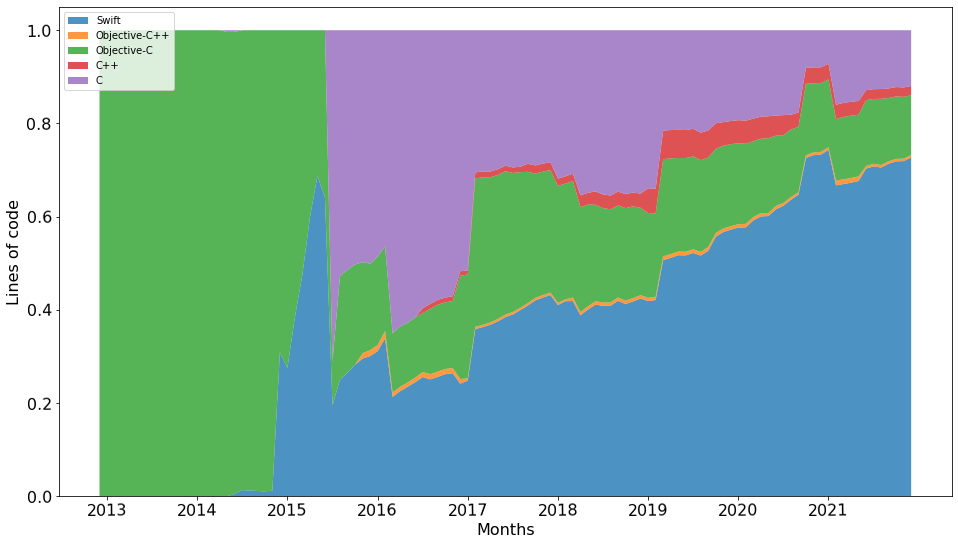

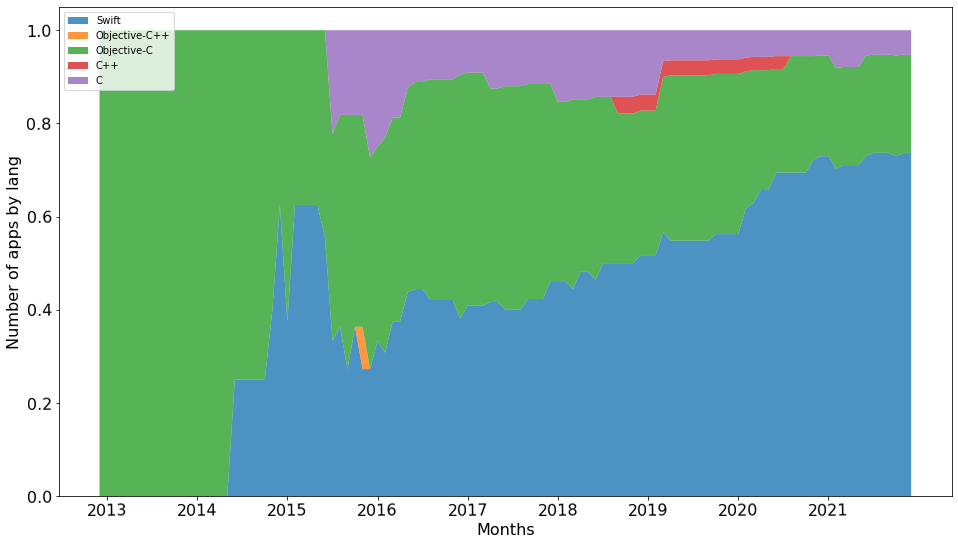

In [18]:
if APPS_PLOT:
    class AppMontlyClocReportsCfg:
        def load_date(self, report):
            return report['date']
        
        def load_key(self, report):
            return report['app']
        
        def load_release(self, report):
            return {
                'release': to_month(self.load_date(report)),
                'cloc_langs': report['cloc_report']['langs']
            }
        
        def date_range(self, earliest_date, latest_date):
            return monthly_range(earliest_date, latest_date)
        
        def date_key(self, d):
            return d.year, d.month
        
        def release_date(self, release):
            return release['release']
        
        date_step = one_month
    col = create_client()[DB][CLOC_REPORTS_APPS]
    bad_apps = list({doc['_id'] for doc in col.aggregate([
        {
            '$match': {
                'cloc_report.success': False
            }
        },
        {
            '$group': {'_id': '$app'}
        }
    ])})

    
    earliest_date = col.find_one({}, {'date': 1, '_id': 0}, sort=[('date', 1)])['date']
    # earliest_date = datetime(2016, 1, 1)
    # latest_date = col.find_one({}, {'date': 1, '_id': 0}, sort=[('date', -1)])['date']

    latest_date = datetime(2021, 12, 31)
    raw_reports = col.find({
        'cloc_report.success': True,
        'app': {
            '$not': {
                '$in': bad_apps
            }
        }
    })

    timeline = TimelineBuilder(AppMontlyClocReportsCfg()).build(raw_reports, earliest_date, latest_date)
    months, data = aggregate_timeline(timeline, line_count, normalize=False)
    last_snapshot(data)
    language_plot(months, data, 'Language usage over the years in open source apps', 'Lines of code', fname=plot_path('langs_in_apps.png'))
    months, data = aggregate_timeline(timeline, most_prevalent_lang, normalize=False)
    language_plot(months, data, 'Language prevalence over the years in open source apps', 'Number of apps by predominat language', fname=plot_path('langs_in_apps_prevalence.png'))
    last_snapshot(data)
    months, data = aggregate_timeline(timeline, line_count)
    language_plot(months, data, 'Language usage over the years in open source apps (Normalized)', 'Lines of code', fname=plot_path('langs_in_apps_norm.png'))
    months, data = aggregate_timeline(timeline, most_prevalent_lang)
    language_plot(months, data, 'Language usage over the years in open source apps (Normalized)', 'Number of apps by lang', fname=plot_path('langs_in_apps_norm.png'))
    # print(search_month_of_predominancy('Swift', data, months))

    if False:
        from collections import defaultdict
        apps = defaultdict(list)
        for doc in col.find({'cloc_report': {'$exists': True}}):
            apps[doc['app']].append(doc)

        all_deltas = []
        for app, commits in apps.items():
            commits = sorted(commits, key=lambda x: x['date'])
            deltas = zip(commits, commits[1:])
            for left, right in deltas:
                if not (left['cloc_report']['success'] and right['cloc_report']['success']):
                    continue
                langs = {x['lang'] for x in left['cloc_report']['langs']} | {x['lang'] for x in right['cloc_report']['langs']}
                left_langs = {
                    x['lang']: x['stats'] for x in left['cloc_report']['langs']
                }
                
                right_langs = {
                    x['lang']: x['stats'] for x in right['cloc_report']['langs']
                }
                lang_delta = {}
                for lang in langs:
                    lang_delta[lang] = left_langs.get(lang, {'code': 0})['code'] - right_langs.get(lang, {'code': 0})['code']
                d = {
                    'left': left['commit'],
                    'right': right['commit'],
                    'app': app,
                    'c_code_delta': lang_delta.get("C", 0)
                }
                all_deltas.append(d)

        for delta in sorted(all_deltas, key=lambda x:x['c_code_delta'])[:10]:
            print(f"{delta['app']} | {delta['right']} | {delta['c_code_delta']}")
    


In [19]:
import pandas as pd
from IPython.display import display

if APPS_PLOT:
    col = create_client()[DB][CLOC_REPORTS_APPS]
    results = col.aggregate([
        {
            '$group': {
                '_id': '$app',
                'commit_count': {
                    '$sum': 1
                },
                'earliest_commit': {
                    '$min': '$date'
                },
                'latest_commit': {
                    '$max': '$date'
                }
            }
        },
        {
            '$sort': {
                'latest_commit': 1
            }
        }
    ])
    df = pd.DataFrame(results)
    display(df.head(50))

,_id,commit_count,earliest_commit,latest_commit
0,C-41,250,2013-12-22 00:27:04,2017-02-10 14:07:08
1,Open Event Organizer,47,2017-11-24 13:11:11,2019-05-11 09:40:59
2,FlappySwift,148,2014-06-02 20:29:48,2019-11-19 23:06:10
3,Dash,299,2016-11-06 17:31:44,2020-01-30 10:13:04
4,CI2Go,335,2018-06-16 23:43:48,2020-05-28 10:31:03
5,Corona Tracker,804,2020-03-02 09:14:36,2020-10-25 14:37:27
6,Edhita,210,2010-08-08 14:40:44,2021-03-16 00:57:17
7,Monkey,269,2015-06-09 12:06:55,2021-04-25 12:12:01
8,MAPS.ME,42729,2015-09-22 19:33:57,2021-04-28 14:44:52
9,MovieSwiftUI,686,2019-06-06 19:19:47,2021-06-07 05:45:32


# Number of unique repos in the dataset 
10+ hours computation!

In [20]:
if COMPUTE_UNIQUE_REPOS:
    result = create_client()[DB][CLOC_REPORTS].aggregate([
    {
        '$lookup': {
            'from': COCOAPODS, 
            'localField': 'name', 
            'foreignField': 'name', 
            'as': 'pods'
        }
    }, {
        '$unwind': '$pods'
    }, {
        '$match': {
            '$expr': {
                '$eq': [
                    '$version', '$pods.version'
                ]
            }
        }
    }, {
        '$group': {
            '_id': '$pods.source.git'
        }
    }, {
        '$group': {
            '_id': 0, 
            'count': {
                '$sum': 1
            }
        }
    }
])
    result = next(result)
    print(result)